In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
from tqdm import tqdm

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
batch_size = 64
train_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616]),
    ])

val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616])
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=val_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
from torchvision.models import resnet50
model = resnet50(num_classes=10, pretrained=False).to(device)

/home/server-96gb-ailab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/server-96gb-ailab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# Train

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)  

In [6]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [7]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 50

In [8]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

  0%|          | 0/782 [00:00<?, ?it/s]

100%|██████████| 782/782 [02:15<00:00,  5.75it/s]


Epoch [  1/ 50] 	 Loss: 1.56006     Accuracy: 43.08% 	 Test Loss: 1.24752     Test Accuracy: 55.37%


100%|██████████| 782/782 [02:41<00:00,  4.85it/s]


Epoch [  2/ 50] 	 Loss: 1.01548     Accuracy: 63.60% 	 Test Loss: 1.40604     Test Accuracy: 56.86%


100%|██████████| 782/782 [02:40<00:00,  4.88it/s]


Epoch [  3/ 50] 	 Loss: 0.78601     Accuracy: 72.31% 	 Test Loss: 0.75741     Test Accuracy: 74.45%


100%|██████████| 782/782 [02:40<00:00,  4.88it/s]


Epoch [  4/ 50] 	 Loss: 0.62386     Accuracy: 78.25% 	 Test Loss: 0.60301     Test Accuracy: 79.15%


100%|██████████| 782/782 [02:40<00:00,  4.88it/s]


Epoch [  5/ 50] 	 Loss: 0.51472     Accuracy: 81.97% 	 Test Loss: 0.57067     Test Accuracy: 80.34%


100%|██████████| 782/782 [02:40<00:00,  4.87it/s]


Epoch [  6/ 50] 	 Loss: 0.43857     Accuracy: 84.77% 	 Test Loss: 0.58235     Test Accuracy: 79.80%


100%|██████████| 782/782 [02:41<00:00,  4.83it/s]


Epoch [  7/ 50] 	 Loss: 0.37358     Accuracy: 86.88% 	 Test Loss: 0.57035     Test Accuracy: 81.47%


100%|██████████| 782/782 [02:40<00:00,  4.86it/s]


Epoch [  8/ 50] 	 Loss: 0.30971     Accuracy: 89.02% 	 Test Loss: 0.56420     Test Accuracy: 81.55%


100%|██████████| 782/782 [02:41<00:00,  4.85it/s]


Epoch [  9/ 50] 	 Loss: 0.25857     Accuracy: 90.91% 	 Test Loss: 0.61174     Test Accuracy: 80.43%


100%|██████████| 782/782 [02:41<00:00,  4.86it/s]


Epoch [ 10/ 50] 	 Loss: 0.20671     Accuracy: 92.62% 	 Test Loss: 0.55570     Test Accuracy: 83.31%


100%|██████████| 782/782 [02:42<00:00,  4.81it/s]


Epoch [ 11/ 50] 	 Loss: 0.17112     Accuracy: 93.95% 	 Test Loss: 0.60917     Test Accuracy: 82.59%


100%|██████████| 782/782 [02:42<00:00,  4.80it/s]


Epoch [ 12/ 50] 	 Loss: 0.14105     Accuracy: 95.01% 	 Test Loss: 0.64266     Test Accuracy: 82.82%


100%|██████████| 782/782 [02:42<00:00,  4.82it/s]


Epoch [ 13/ 50] 	 Loss: 0.10995     Accuracy: 96.13% 	 Test Loss: 0.62514     Test Accuracy: 83.95%


100%|██████████| 782/782 [02:40<00:00,  4.87it/s]


Epoch [ 14/ 50] 	 Loss: 0.10107     Accuracy: 96.32% 	 Test Loss: 0.73141     Test Accuracy: 82.86%


100%|██████████| 782/782 [02:42<00:00,  4.82it/s]


Epoch [ 15/ 50] 	 Loss: 0.08708     Accuracy: 96.87% 	 Test Loss: 0.62976     Test Accuracy: 84.36%


100%|██████████| 782/782 [02:41<00:00,  4.83it/s]


Epoch [ 16/ 50] 	 Loss: 0.07785     Accuracy: 97.30% 	 Test Loss: 0.64607     Test Accuracy: 84.61%


100%|██████████| 782/782 [02:43<00:00,  4.79it/s]


Epoch [ 17/ 50] 	 Loss: 0.06726     Accuracy: 97.73% 	 Test Loss: 0.70741     Test Accuracy: 83.83%


100%|██████████| 782/782 [02:41<00:00,  4.85it/s]


Epoch [ 18/ 50] 	 Loss: 0.06352     Accuracy: 97.82% 	 Test Loss: 0.66830     Test Accuracy: 84.13%


100%|██████████| 782/782 [02:41<00:00,  4.85it/s]


Epoch [ 19/ 50] 	 Loss: 0.06001     Accuracy: 97.96% 	 Test Loss: 0.75648     Test Accuracy: 83.27%


100%|██████████| 782/782 [02:41<00:00,  4.85it/s]


Epoch [ 20/ 50] 	 Loss: 0.05393     Accuracy: 98.10% 	 Test Loss: 0.77389     Test Accuracy: 83.27%


100%|██████████| 782/782 [02:41<00:00,  4.84it/s]


Epoch [ 21/ 50] 	 Loss: 0.05526     Accuracy: 98.05% 	 Test Loss: 0.77388     Test Accuracy: 83.86%


100%|██████████| 782/782 [02:41<00:00,  4.85it/s]


Epoch [ 22/ 50] 	 Loss: 0.05059     Accuracy: 98.19% 	 Test Loss: 0.74497     Test Accuracy: 84.70%


100%|██████████| 782/782 [02:41<00:00,  4.85it/s]


Epoch [ 23/ 50] 	 Loss: 0.04579     Accuracy: 98.35% 	 Test Loss: 0.82500     Test Accuracy: 83.63%


100%|██████████| 782/782 [02:41<00:00,  4.86it/s]


Epoch [ 24/ 50] 	 Loss: 0.04114     Accuracy: 98.55% 	 Test Loss: 0.77903     Test Accuracy: 84.23%


100%|██████████| 782/782 [02:41<00:00,  4.85it/s]


Epoch [ 25/ 50] 	 Loss: 0.04352     Accuracy: 98.46% 	 Test Loss: 0.76975     Test Accuracy: 85.04%


100%|██████████| 782/782 [02:40<00:00,  4.87it/s]


Epoch [ 26/ 50] 	 Loss: 0.03645     Accuracy: 98.71% 	 Test Loss: 0.75520     Test Accuracy: 84.68%


100%|██████████| 782/782 [02:40<00:00,  4.87it/s]


Epoch [ 27/ 50] 	 Loss: 0.04174     Accuracy: 98.59% 	 Test Loss: 0.77484     Test Accuracy: 84.75%


100%|██████████| 782/782 [02:39<00:00,  4.90it/s]


Epoch [ 28/ 50] 	 Loss: 0.03144     Accuracy: 98.95% 	 Test Loss: 0.88969     Test Accuracy: 84.12%


100%|██████████| 782/782 [02:39<00:00,  4.89it/s]


Epoch [ 29/ 50] 	 Loss: 0.03907     Accuracy: 98.64% 	 Test Loss: 0.81632     Test Accuracy: 84.87%


100%|██████████| 782/782 [02:39<00:00,  4.90it/s]


Epoch [ 30/ 50] 	 Loss: 0.03050     Accuracy: 99.01% 	 Test Loss: 0.76519     Test Accuracy: 84.65%


100%|██████████| 782/782 [02:39<00:00,  4.90it/s]


Epoch [ 31/ 50] 	 Loss: 0.04033     Accuracy: 98.64% 	 Test Loss: 0.78042     Test Accuracy: 84.76%


100%|██████████| 782/782 [02:39<00:00,  4.89it/s]


Epoch [ 32/ 50] 	 Loss: 0.02688     Accuracy: 99.10% 	 Test Loss: 0.88274     Test Accuracy: 84.22%


100%|██████████| 782/782 [02:40<00:00,  4.89it/s]


Epoch [ 33/ 50] 	 Loss: 0.02954     Accuracy: 98.98% 	 Test Loss: 0.84121     Test Accuracy: 84.32%


100%|██████████| 782/782 [02:39<00:00,  4.90it/s]


Epoch [ 34/ 50] 	 Loss: 0.03052     Accuracy: 98.97% 	 Test Loss: 0.84563     Test Accuracy: 84.13%


100%|██████████| 782/782 [02:39<00:00,  4.91it/s]


Epoch [ 35/ 50] 	 Loss: 0.02611     Accuracy: 99.13% 	 Test Loss: 0.81300     Test Accuracy: 84.26%


100%|██████████| 782/782 [02:42<00:00,  4.82it/s]


Epoch [ 36/ 50] 	 Loss: 0.02821     Accuracy: 98.97% 	 Test Loss: 0.80913     Test Accuracy: 84.42%


100%|██████████| 782/782 [02:42<00:00,  4.80it/s]


Epoch [ 37/ 50] 	 Loss: 0.02444     Accuracy: 99.16% 	 Test Loss: 0.78371     Test Accuracy: 84.58%


100%|██████████| 782/782 [02:41<00:00,  4.83it/s]


Epoch [ 38/ 50] 	 Loss: 0.02724     Accuracy: 99.02% 	 Test Loss: 0.89038     Test Accuracy: 84.25%


100%|██████████| 782/782 [02:41<00:00,  4.83it/s]


Epoch [ 39/ 50] 	 Loss: 0.02320     Accuracy: 99.17% 	 Test Loss: 0.80907     Test Accuracy: 84.85%


100%|██████████| 782/782 [02:41<00:00,  4.84it/s]


Epoch [ 40/ 50] 	 Loss: 0.02115     Accuracy: 99.31% 	 Test Loss: 0.84850     Test Accuracy: 85.63%


100%|██████████| 782/782 [02:11<00:00,  5.93it/s]


Epoch [ 41/ 50] 	 Loss: 0.02844     Accuracy: 99.09% 	 Test Loss: 0.78815     Test Accuracy: 85.03%


100%|██████████| 782/782 [02:11<00:00,  5.96it/s]


Epoch [ 42/ 50] 	 Loss: 0.01910     Accuracy: 99.35% 	 Test Loss: 0.86254     Test Accuracy: 84.81%


100%|██████████| 782/782 [02:11<00:00,  5.95it/s]


Epoch [ 43/ 50] 	 Loss: 0.02507     Accuracy: 99.15% 	 Test Loss: 0.85235     Test Accuracy: 85.10%


100%|██████████| 782/782 [02:11<00:00,  5.95it/s]


Epoch [ 44/ 50] 	 Loss: 0.02022     Accuracy: 99.34% 	 Test Loss: 0.80392     Test Accuracy: 85.20%


100%|██████████| 782/782 [02:11<00:00,  5.96it/s]


Epoch [ 45/ 50] 	 Loss: 0.01821     Accuracy: 99.37% 	 Test Loss: 0.93527     Test Accuracy: 85.16%


100%|██████████| 782/782 [02:11<00:00,  5.96it/s]


Epoch [ 46/ 50] 	 Loss: 0.02182     Accuracy: 99.27% 	 Test Loss: 0.86841     Test Accuracy: 84.90%


100%|██████████| 782/782 [02:11<00:00,  5.97it/s]


Epoch [ 47/ 50] 	 Loss: 0.01944     Accuracy: 99.35% 	 Test Loss: 0.85222     Test Accuracy: 85.02%


100%|██████████| 782/782 [02:11<00:00,  5.96it/s]


Epoch [ 48/ 50] 	 Loss: 0.01921     Accuracy: 99.31% 	 Test Loss: 0.91702     Test Accuracy: 83.19%


100%|██████████| 782/782 [02:12<00:00,  5.91it/s]


Epoch [ 49/ 50] 	 Loss: 0.01952     Accuracy: 99.37% 	 Test Loss: 0.81714     Test Accuracy: 85.15%


100%|██████████| 782/782 [02:11<00:00,  5.94it/s]


Epoch [ 50/ 50] 	 Loss: 0.02066     Accuracy: 99.28% 	 Test Loss: 0.85029     Test Accuracy: 85.45%


In [9]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%")


Best epoch: 40 with test accuracy: 85.63%


# Plot results

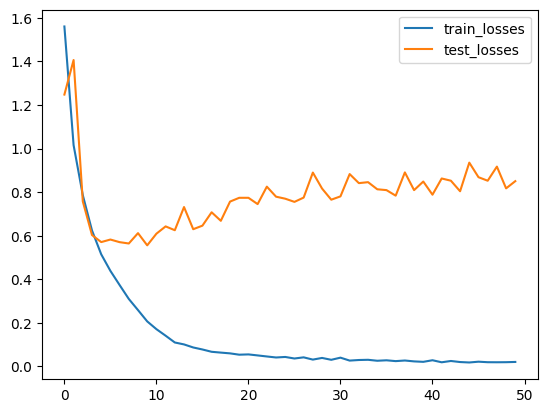

In [10]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

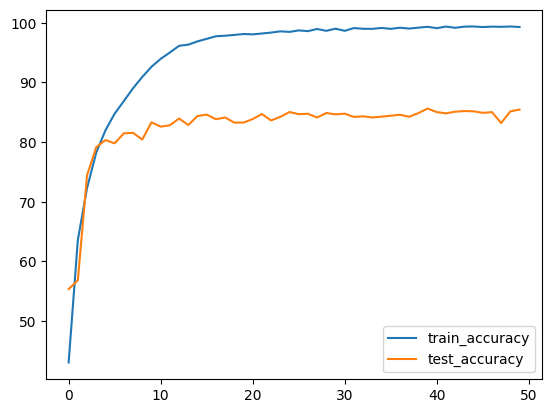

In [11]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()